# Solucion problema de clustering
## _Prueba tecnica Globant *p1*_
### Objetvo
En este documento se realiza una exploracion base para el problema de clustering del modelo, identificando patrones clave en el comportamiento de las distintas variables. para desbelar un poco que tipo de aproximacion matematica describe mejor el comportamiento de los datos.

### Etapas
- Importar datos unificados
- revisar caracteristicas y tipologias
- Transformacion de variables no numericas
- Correlacion/heatmaps
- PCA

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from Funciones import Explorer

In [2]:
DATA_DIR="/home/grupodot/Documentos/Examen_globant/Purchase-Card-Transactions_GLBNT_TESTT/Data/"

In [3]:
expl = Explorer()
df = expl.importar_d(DATA_DIR)
print("La dimension de la base es: ", df.shape)
df.head()

La dimension de la base es:  (47803, 13)


,TRANS DATE,TRANS VAT DESC,ORIGINAL GROSS AMT,MERCHANT NAME,CARD NUMBER,TRANS CAC CODE 1,TRANS CAC DESC 1,TRANS CAC CODE 2,TRANS CAC DESC 2,TRANS CAC CODE 3,Directorate,BILLING CUR CODE,Unnamed: 10
0,2015-03-08,VR,35.96,fasthosts internet,************3497,L9Y0,Computing Other,RV3VG,AD Adults Strategy,A00,Adult & Communities,NaN,NaN
1,2015-03-23,VR,12.24,fast key services,************4094,L100,Equip Operational,RV3A7,Hodge Hill Adult Team,A00,Adult & Communities,NaN,NaN
2,2015-03-22,VR,52.45,acocks green 224,************4302,K020,Vehicle Fuel,RV14R,Mobile Night Care Service,A00,Adult & Communities,NaN,NaN
3,2015-03-09,VR,40.66,esso aston way ss,************6316,K020,Vehicle Fuel,RV14R,Mobile Night Care Service,A00,Adult & Communities,NaN,NaN
4,2015-03-29,VR,59.57,esso aston way ss,************1287,K020,Vehicle Fuel,RV14R,Mobile Night Care Service,A00,Adult & Communities,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47803 entries, 0 to 47802
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   TRANS DATE          47803 non-null  datetime64[ns]
 1   TRANS VAT DESC      46888 non-null  object        
 2   ORIGINAL GROSS AMT  47803 non-null  float64       
 3   MERCHANT NAME       47803 non-null  object        
 4   CARD NUMBER         47803 non-null  object        
 5   TRANS CAC CODE 1    47795 non-null  object        
 6   TRANS CAC DESC 1    47795 non-null  object        
 7   TRANS CAC CODE 2    47792 non-null  object        
 8   TRANS CAC DESC 2    47792 non-null  object        
 9   TRANS CAC CODE 3    47790 non-null  object        
 10  Directorate         43844 non-null  object        
 11  BILLING CUR CODE    34467 non-null  object        
 12  Unnamed: 10         3959 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(11)
m

Las 13 variables que tenemos registradas tienen en promedi mas de 45.000 datos. Algunas tienen una menor cantidad en variables categoricas como "unnamed" o "billing cur code", mas adelante exploraremos un poco mas estos casos.
se proponé un embeding a las variables categoricas, asi podremos medir su espectro de salidas y distribucion de una manera mas visible

Text(0.5, 1.0, 'Monto total por fecha')

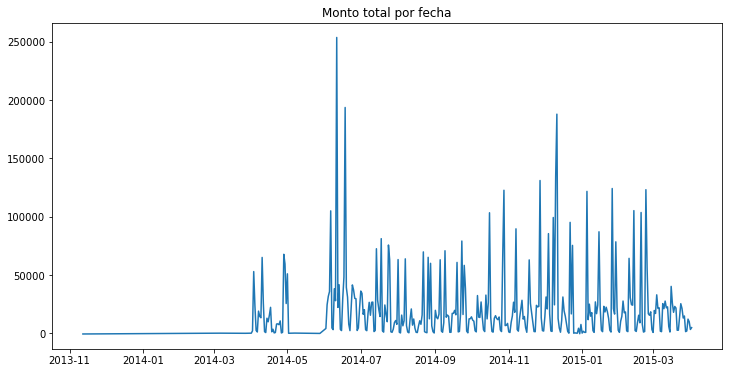

In [5]:
# Revision de registros en cada periodo

plt.figure(figsize=(12, 6))
plt.plot((df.groupby(by =["TRANS DATE"]).sum()))
plt.title("Monto total por fecha")

Text(0.5, 1.0, 'Monto total por fecha en (LN)')

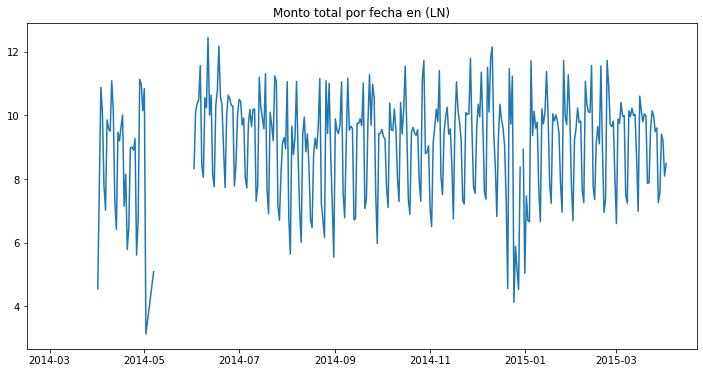

In [6]:
# Revision de registros en cada periodo

plt.figure(figsize=(12, 6))
plt.plot(np.log(df.groupby(by =["TRANS DATE"]).sum()))
plt.title("Monto total por fecha en (LN)")

Text(0.5, 1.0, 'Histograma de los datos totales')

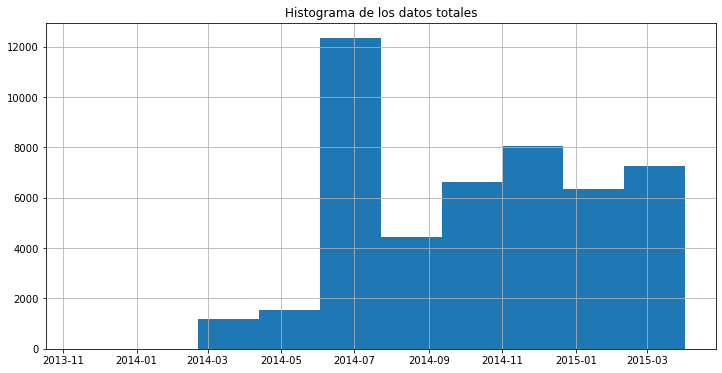

In [7]:
# Revision de registros en cada periodo

plt.figure(figsize=(12, 6))
plt.hist(df["TRANS DATE"])
plt.grid()
plt.title("Histograma de los datos totales")

Text(0.5, 1.0, 'Histograma de los datos cuando Billing Cur Code es NaN')

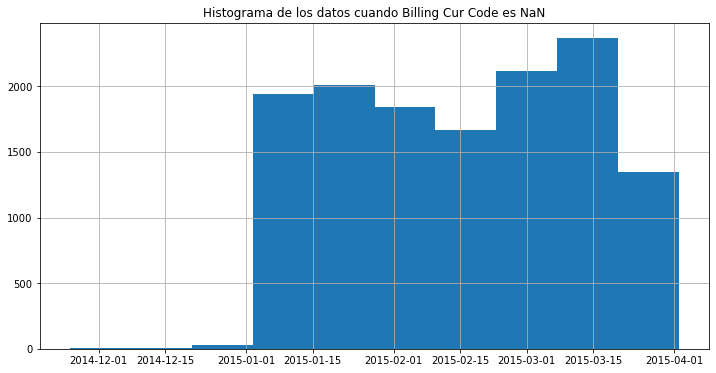

In [8]:
# Revision de registros en cada periodo cuando la variable de menos registros es nula

plt.figure(figsize=(12, 6))
plt.hist(df[df["BILLING CUR CODE"]!="GBP"]["TRANS DATE"])
plt.grid()
plt.title("Histograma de los datos cuando Billing Cur Code es NaN")

Existe evidencia de que la mayor consentracion de nulos en la variable de mayor cantidad de nulos se encuentran a partir del 2020, por esto se tomarán los valores nulos como una salida posible y no como un error de medicion 

In [9]:
#creamos un vector con las variables categoricas y eliminamos nan

to_numeric =  (df.select_dtypes(include=["object"]).copy()).columns
df_f = df.fillna("noreg")

In [10]:
#

ord_enc = OrdinalEncoder()
df_f[to_numeric] = ord_enc.fit_transform(df_f[to_numeric])
df_f.describe()

,TRANS VAT DESC,ORIGINAL GROSS AMT,MERCHANT NAME,CARD NUMBER,TRANS CAC CODE 1,TRANS CAC DESC 1,TRANS CAC CODE 2,TRANS CAC DESC 2,TRANS CAC CODE 3,Directorate,BILLING CUR CODE,Unnamed: 10
count,47803.000000,47803.000000,47803.000000,47803.000000,47803.000000,47803.000000,47803.000000,47803.000000,47803.000000,47803.000000,47803.000000,47803.000000
mean,4.571261,158.331458,2297.651905,552.437169,51.877163,54.656967,388.251951,466.267473,0.244211,7.130891,0.278978,9.617304
std,1.550038,1958.036331,1905.590212,304.734431,21.694383,31.078966,250.273340,264.175416,2.062509,3.287610,0.448502,1.439584
min,0.000000,-6794.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,12.700000,289.000000,299.000000,35.000000,28.000000,179.000000,228.000000,0.000000,6.000000,0.000000,10.000000
50%,6.000000,39.980000,1969.000000,572.000000,55.000000,58.000000,280.000000,432.000000,0.000000,6.000000,0.000000,10.000000
75%,6.000000,85.000000,4162.000000,815.000000,60.000000,84.000000,679.000000,717.000000,0.000000,11.000000,1.000000,10.000000
max,7.000000,106289.880000,5986.000000,1060.000000,105.000000,105.000000,911.000000,904.000000,25.000000,13.000000,1.000000,10.000000


/home/grupodot/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


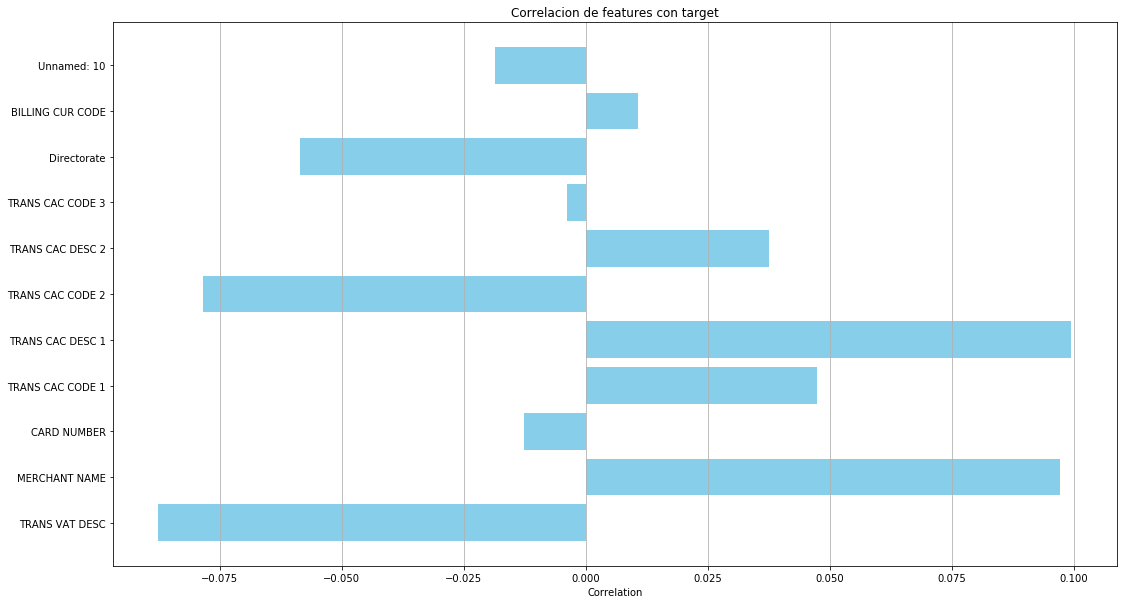

In [11]:
plt.figure(figsize=(18, 10))
plt.barh(to_numeric, df_f[to_numeric].corrwith(np.log(df_f["ORIGINAL GROSS AMT"])), color= 'skyblue')
plt.xlabel('Correlation')
plt.title('Correlacion de features con target')
plt.grid(axis='x')

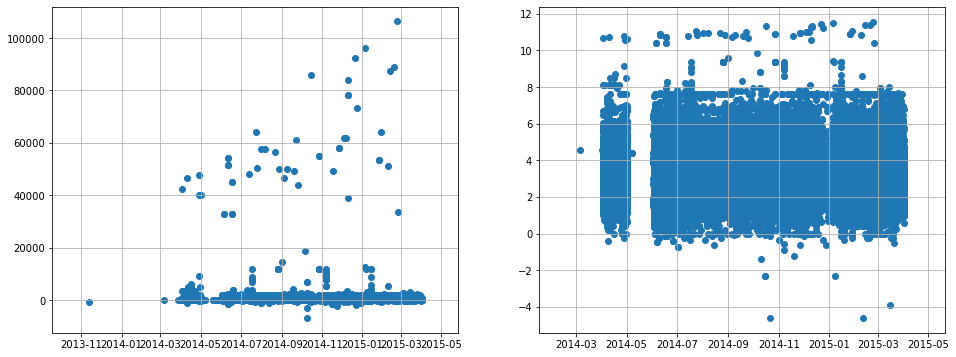

In [12]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (16,6))
ax1.scatter(df["TRANS DATE"], (df["ORIGINAL GROSS AMT"]))
ax2.scatter(df["TRANS DATE"], np.log(df["ORIGINAL GROSS AMT"]))
ax1.grid()
ax2.grid()

/usr/lib/python3/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/lib/python3/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


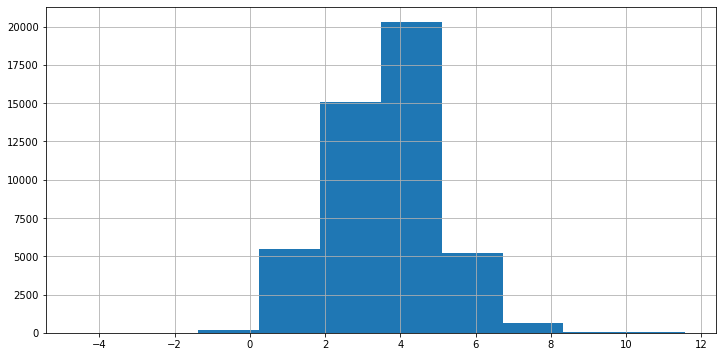

In [13]:
plt.figure(figsize=(12, 6))
plt.hist(np.log(df["ORIGINAL GROSS AMT"]))
plt.grid()

In [14]:
dates = df_f["TRANS DATE"]
df_f = df_f.drop(["TRANS DATE"], axis=1)
df_f.head()

,TRANS VAT DESC,ORIGINAL GROSS AMT,MERCHANT NAME,CARD NUMBER,TRANS CAC CODE 1,TRANS CAC DESC 1,TRANS CAC CODE 2,TRANS CAC DESC 2,TRANS CAC CODE 3,Directorate,BILLING CUR CODE,Unnamed: 10
0,3.0,35.96,1379.0,339.0,86.0,17.0,804.0,7.0,0.0,0.0,1.0,10.0
1,3.0,12.24,1376.0,414.0,55.0,28.0,791.0,391.0,0.0,0.0,1.0,10.0
2,3.0,52.45,72.0,451.0,32.0,96.0,764.0,492.0,0.0,0.0,1.0,10.0
3,3.0,40.66,1285.0,668.0,32.0,96.0,764.0,492.0,0.0,0.0,1.0,10.0
4,3.0,59.57,1285.0,139.0,32.0,96.0,764.0,492.0,0.0,0.0,1.0,10.0


In [15]:
scaler=StandardScaler()
scaler.fit(df_f)
scaled_data=scaler.transform(df_f)

In [16]:
# t=pd.DataFrame(data=scaled_data, columns=df.columns[1:])
t.describe()

NameError: name 't' is not defined

In [17]:
pca2=PCA(n_components=2)
pca2.fit(scaled_data)

PCA(n_components=2)

In [18]:
x_pca=pca2.transform(scaled_data)

/home/grupodot/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
No handles with labels found to put in legend.


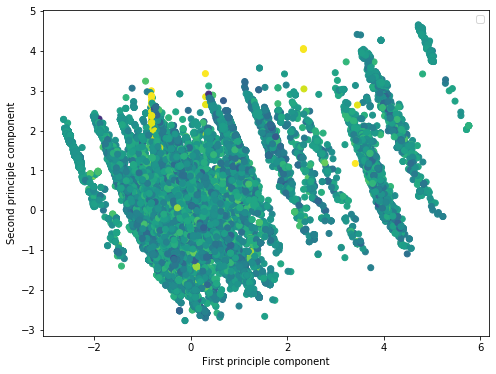

In [19]:
plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0],x_pca[:,1],c=np.log(df_f["ORIGINAL GROSS AMT"]))
plt.xlabel('First principle component')
plt.ylabel('Second principle component')
plt.legend()

In [47]:
x = df_f.iloc[:, :-1].values
y = df_f.iloc[:, -1].values
x = StandardScaler().fit_transform(x)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=0)

In [48]:
lreg = LogisticRegression()
lreg.fit(x_train, y_train)
y_pred = lreg.predict(x_test)

/home/grupodot/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [49]:
accuracy = accuracy_score(y_test, y_pred) * 100
print("Accuracy of the Logistic Regression Model: ",accuracy)

Accuracy of the Logistic Regression Model:  97.94296074192873


Text(0.5, 1.0, 'Salidas de la prediccion vs las reales')

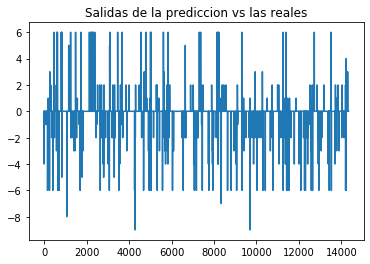

In [50]:
plt.plot((y_pred-y_test))
plt.title("Salidas de la prediccion vs las reales")